In [30]:
# %autosave 0
import warnings
warnings.filterwarnings(action='ignore')

import os

import numpy as np
import pandas as pd
import seaborn as sb

from IPython.display import Image

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam    # 가중치, bias 최적화

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

import matplotlib.pyplot as plt

from matplotlib import font_manager, rc

import platform 

if (platform.system() == 'Windows'):  # Windows, Linux, Darwin
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    plt.rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd1/dnn/recommend_exercise' # Colab

plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

In [56]:
# class: 0 ~ 4
# data = np.loadtxt(path + '/book5.csv', delimiter=',', skiprows=1, dtype=np.float64)   # 특성이 작은 데이터의 예외 추가
# class: 1 ~ 5
data = np.loadtxt(path + '/book6.csv', delimiter=',', skiprows=1, dtype=np.float64)   # 특성이 작은 데이터의 예외 추가
print(data.shape)
print(data[0])
print(data[0][25])

(50, 26)
[0.96 0.01 0.01 0.01 0.01 0.96 0.01 0.01 0.01 0.01 0.96 0.01 0.01 0.01
 0.01 0.96 0.01 0.01 0.01 0.01 0.96 0.01 0.01 0.01 0.01 1.  ]
1.0


In [58]:
X = data[:, 0:25]  # 0 ~ 24
Y = (data[:, 25]).astype('int') # 25 번째 데이터, class의 분리

# 1부터 class가 할당된 경우는 -1을 함
# Y = (data[:, 25]).astype('int') - 1 # 25 번째 데이터, class의 분리

Y = Y.astype('int') # 정수로 형변환
print(Y)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4]


In [47]:
# 0: 걷기/달리기
# 1: 필라테스/요가
# 2: 자전거
# 3: 줄넘기/점프
# 4: 수영
Y_encoded = to_categorical(Y) # one-hot-encoding

In [48]:
print(X[0])
print(Y_encoded[0])

[0.96 0.01 0.01 0.01 0.01 0.96 0.01 0.01 0.01 0.01 0.96 0.01 0.01 0.01
 0.01 0.96 0.01 0.01 0.01 0.01 0.96 0.01 0.01 0.01 0.01]
[1. 0. 0. 0. 0.]


In [49]:
# train_test_split 분할을 통한 훈련, 검증, 테스트 데이터의 분리
seed = 0
# 90%: 분할대기, 10%: 테스트
x_train_all, x_test, y_train_all, y_test = train_test_split(X, Y_encoded,
                                           stratify=Y_encoded,
                                           test_size=0.1,
                                           random_state=seed)
# 나머지 데이터 90%를 분할, 80%: 훈련, 20%: 검증
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                           stratify=y_train_all,
                                           test_size=0.2,
                                           random_state=seed)

print(y_val)
print(y_val.shape)
# Iris-setosa: 0, Iris-versicolor: 1, Iris-virginica: 2
# (7, 3): 7개의 데이터가 입력되어 한건당 3가지에 속할 확률이 출력됨으로 7행 3열이됨.

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
(9, 5)


In [50]:
print(y_test)
print(y_test.shape)

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
(5, 5)


In [51]:
model = Sequential()

# 네트워크 구성
# model.add(Dense(20, input_shape=(9, ), activation='relu'))
model.add(Dense(5, input_dim=25, activation='relu'))
model.add(Dense(5, activation='softmax')) # 입력: 1,0,0,1,0,0,1,0,0 → 0 ~ 1 사이의 확률 3가지 출력, 총합은 1
model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', 
                                metrics=['accuracy'])
model.summary()

mcp = ModelCheckpoint(filepath='./exercise.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

es = EarlyStopping(monitor='loss', patience=1, restore_best_weights=True)

hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), shuffle=True,
                 epochs=50, batch_size=1, callbacks=[mcp, es])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 5)                 130       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 30        
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
36/36 [==============================] - 1s 10ms/step - loss: 1.5367 - accuracy: 0.1918 - val_loss: 1.1720 - val_accuracy: 0.6667

Epoch 00001: val_accuracy improved from -inf to 0.66667, saving model to .\exercise.h5
Epoch 2/50
36/36 [==============================] - 0s 4ms/step - loss: 1.2388 - accuracy: 0.5226 - val_loss: 0.8995 - val_accuracy: 0.7778

Epoch 00002: val_accuracy improved from 0.66667 to 0.77778, saving model to .\exercise.h5
Epoch 3/50
36/36 [==============================] - 0s 4ms

36/36 [==============================] - 0s 4ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 1.0000

Epoch 00039: val_accuracy did not improve from 1.00000
Epoch 40/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 1.0000

Epoch 00040: val_accuracy did not improve from 1.00000
Epoch 41/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 1.0000

Epoch 00041: val_accuracy did not improve from 1.00000
Epoch 42/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 1.0000

Epoch 00042: val_accuracy did not improve from 1.00000
Epoch 43/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0046 - val_accuracy: 1.0000

Epoch 00043: val_accuracy did not improve from 1.00000
Epoch 44/50
36/36 [========

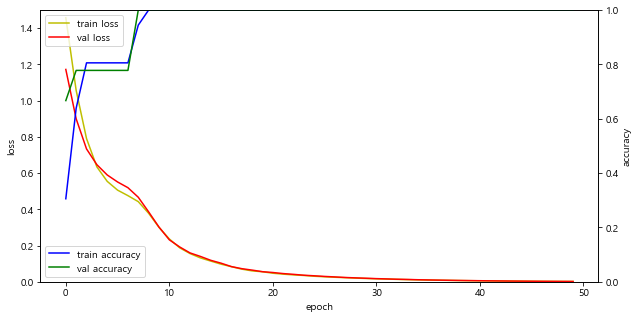

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.5]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch' )  # 학습 횟수
loss_ax.set_ylabel('loss')    # 왼쪽 y 축 레이블, 오차
acc_ax.set_ylabel('accuracy') # 오른쪽 y 축 레이블,정확도

loss_ax.legend(loc='upper left') # 왼쪽 y 축 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 오른쪽 y 축 정확도 레이블 위치

plt.show()

In [53]:
test_loss, test_acc = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.001849995693191886 /정확도: 100.0 %


In [54]:
print('데이터:', x_test.shape) # 변수가 9개로 구성된 4건의 관측치(행)
print('데이터:', x_test[0])    # 첫번째 데이터행

p = model.predict(x_test)      # 테스트 데이터 4건 ★
print('예측 결과 p.shape:', p.shape)     # (4, 3): 3: 폼종의 갯수

데이터: (5, 25)
데이터: [0.01 0.01 0.01 0.01 0.96 0.01 0.01 0.01 0.01 0.96 0.01 0.01 0.01 0.01
 0.96 0.01 0.01 0.01 0.01 0.96 0.01 0.01 0.01 0.01 0.96]
예측 결과 p.shape: (5, 5)


In [55]:
print('예측값:', p[0])        # 첫번째 예측값 출력, 확률 0 ~ 1사이의 실수값
print('예측값의 합: {0:0.3f}'.format(np.sum(p[0])))
print('예측값: {0:.5f}% {1:.5f}% {2:.5f}%'.format(p[0,0]*100,p[0,1]*100,p[0,2]*100))
print('One-hot-encoding: ', y_test[0])
print(np.argmax(p[0]))      # 가장 큰값의 index

예측값: [6.9539425e-07 6.2288335e-03 2.7531574e-05 2.4455597e-04 9.9349844e-01]
예측값의 합: 1.000
예측값: 0.00007% 0.62288% 0.00275%
One-hot-encoding:  [0. 0. 0. 0. 1.]
4
